In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#reading training and test data
taxi_train = pd.read_csv('/content/drive/MyDrive/ml_data/train.csv',nrows=1000000)
taxi_test = pd.read_csv('/content/test.csv')

### Data Cleaning and Visualization

In [ ]:
# Check no of rows & columns in the dataset
print("Shape of the Training data :", taxi_train.shape)

# See all the columns in the dataset
print("All columns are :", list(taxi_train.columns))

Shape of the Training data : (1000000, 8)
All columns are : ['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']


In [ ]:
#seeing the format of dataset
taxi_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
taxi_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999990 non-null   float64
 6   dropoff_latitude   999990 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


* This dataset has 8 columns
* In dropoff_longitude and dropoff_latitude column some values are missing
* We will simply remove these data points

In [ ]:
#removing the rows in which some data is missing
taxi_train.dropna(inplace=True)

In [ ]:
#as key will not help in predicting taxi fare we will simply drop this
taxi_train.drop(['key'],inplace=True,axis=1)

In [ ]:
#as pickup_date as such would not help us in predicting the fare
#we will create new features 
#year, month, date, day_of_week and hour
taxi_train['pickup_datetime'] = pd.to_datetime(taxi_train['pickup_datetime'])
taxi_train['year'] = taxi_train['pickup_datetime'].dt.year
taxi_train['month'] = taxi_train['pickup_datetime'].dt.month
taxi_train['date'] = taxi_train['pickup_datetime'].dt.day
taxi_train['day_of_week'] = taxi_train['pickup_datetime'].dt.dayofweek
taxi_train['hour'] = taxi_train['pickup_datetime'].dt.hour
taxi_train.drop(['pickup_datetime'],inplace=True,axis=1)

In [ ]:
#check the dtypes after conversion
taxi_train.dtypes

fare_amount          float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
year                   int64
month                  int64
date                   int64
day_of_week            int64
hour                   int64
dtype: object

In [ ]:
#We will create a one more feature h_distance
#h_distance is haversine distance
#haversine distance is used to calculate the distance between two places on earth
#on the bases of longitude and latitude of these two points

#let's define a function
def haversine_distance(df):
    R = 6371
    pickup_latitude=df['pickup_latitude']
    pickup_longitude=df['pickup_longitude']
    dropoff_latitude=df['dropoff_latitude']
    dropoff_longitude=df['dropoff_longitude']
    phi1 = np.radians(pickup_latitude)
    phi2 = np.radians(dropoff_latitude)

    delta_phi = np.radians(dropoff_latitude-pickup_latitude)
    delta_lambda = np.radians(dropoff_longitude-pickup_longitude)

    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2

    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    #d = R*c
    d = (R * c) #in kilometers
    
    return  d

In [ ]:
#creating h_distance feature in the training data
#using haversine_distance function created above

taxi_train['h_distance'] = haversine_distance(taxi_train)

In [ ]:
#finally our dataset will look like this
taxi_train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,day_of_week,hour,h_distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17,1.030764
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,8.450134
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,1.389525
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,2.799270
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,1.999157


In [ ]:
#seeing the info of our data
taxi_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999990 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        999990 non-null  float64
 1   pickup_longitude   999990 non-null  float64
 2   pickup_latitude    999990 non-null  float64
 3   dropoff_longitude  999990 non-null  float64
 4   dropoff_latitude   999990 non-null  float64
 5   passenger_count    999990 non-null  int64  
 6   year               999990 non-null  int64  
 7   month              999990 non-null  int64  
 8   date               999990 non-null  int64  
 9   day_of_week        999990 non-null  int64  
 10  hour               999990 non-null  int64  
 11  h_distance         999990 non-null  float64
dtypes: float64(6), int64(6)
memory usage: 99.2 MB


In [ ]:
taxi_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,day_of_week,hour,h_distance
count,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000
mean,11.347953,-72.526699,39.929040,-72.527860,39.919954,1.684941,2011.741103,6.267841,15.697996,3.039870,13.509463,19.090118
std,9.821790,12.057778,7.626087,11.324494,8.201418,1.323907,1.860761,3.436230,8.682472,1.949966,6.513855,362.408033
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.212942
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,2.115922
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.882433
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,16878.303157


* Minimum fare amount is negative (not possible, will remove it)
* 75% fare_amount values are atmost 12.5, but max is 500, it means there are outliers
* In actual latitude ranges from -90 to 90 and longitude ranges from -180 to 180
* We will remove all the longitudes and latitudes outside this range
* Minimum passenger_count is 0 and maximum passenger_count is 208, 75% passenger_count values are atmost 2 (not possible, there are outliers, we have to remove these)
* Minimum h_distance is 0 and maximum h_distance is around 16878, 75% of h_distance values are atmost 4 (it means some h_distances are wrong, we have to remove all these wrong data points)
* year, month, date, day_of_week and hour values appear to be correct

In [ ]:
#setting the range of latitudes between -90 to 90
#setting the range of longitudes between -180 to 180
taxi_train = taxi_train[
    (taxi_train['pickup_latitude']>=-90)
    &(taxi_train['pickup_latitude']<=90)
    &(taxi_train['dropoff_latitude']>=-90)
    &(taxi_train['dropoff_latitude']<=90)
    &(taxi_train['pickup_longitude']>=-180)
    &(taxi_train['pickup_longitude']<=180)
    &(taxi_train['dropoff_longitude']>=-180)
    &(taxi_train['dropoff_longitude']<=180)
    ]



### Removing outliers from longitude and latitude data



In [ ]:
#from internet I found that
#New York latitude = 40.730610
#New York longitude = -73.935242

#so, we can restrict the latitude between 40 and 42
#and longitude between -75 and -73

taxi_train = taxi_train[
    (taxi_train['pickup_latitude']>=40)
    &(taxi_train['pickup_latitude']<=42)
    &(taxi_train['dropoff_latitude']>=40)
    &(taxi_train['dropoff_latitude']<=42)
    &(taxi_train['pickup_longitude']>=-75)
    &(taxi_train['pickup_longitude']<=-73)
    &(taxi_train['dropoff_longitude']>=-75)
    &(taxi_train['dropoff_longitude']<=-73)
    ]

In [ ]:
#removing negative and 0 passenger_count values
#removing negative and 0 fare_amount values
#removing 0 h_distance values

taxi_train=taxi_train[(taxi_train['passenger_count']>0) & (taxi_train['fare_amount']>0) & (taxi_train['h_distance']>0)]

In [ ]:
def haversine_pickup_distance_from_airport(df):
    R = 6371
    jfk_lat = 40.639722
    jfk_long = -73.778889
    pickup_latitude=df['pickup_latitude']
    pickup_longitude=df['pickup_longitude']
    phi1 = np.radians(pickup_latitude)
    phi2 = np.radians(jfk_lat)

    delta_phi = np.radians(jfk_lat-pickup_latitude)
    delta_lambda = np.radians(jfk_long-pickup_longitude)

    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2

    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    #d = R*c
    d = (R * c) #in kilometers
    
    return  d

In [ ]:
def haversine_dropoff_distance_from_airport(df):
    R = 6371
    jfk_lat = 40.639722
    jfk_long = -73.778889
    dropoff_latitude=df['dropoff_latitude']
    dropoff_longitude=df['dropoff_longitude']
    phi1 = np.radians(dropoff_latitude)
    phi2 = np.radians(jfk_lat)

    delta_phi = np.radians(jfk_lat-dropoff_latitude)
    delta_lambda = np.radians(jfk_long-dropoff_longitude)

    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2

    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    #d = R*c
    d = (R * c) #in kilometers
    
    return  d

In [ ]:
# adding two more features 
# 1. pickup location distance from jfk airport
# 2 dropoff location distance from jfk airport

taxi_train['pickup_distance_airport'] = haversine_pickup_distance_from_airport(taxi_train)
taxi_train['dropoff_distance_airport'] = haversine_dropoff_distance_from_airport(taxi_train)

In [ ]:
taxi_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,day_of_week,hour,h_distance,pickup_distance_airport,dropoff_distance_airport
count,965155.000000,965155.000000,965155.000000,965155.000000,965155.000000,965155.000000,965155.000000,965155.000000,965155.000000,965155.000000,965155.000000,965155.000000,965155.000000,965155.000000
mean,11.343919,-73.975439,40.750972,-73.974548,40.751314,1.691277,2011.744769,6.271204,15.691056,3.039708,13.509859,3.367343,20.912447,20.958432
std,9.666209,0.036274,0.028165,0.035346,0.031532,1.306270,1.867495,3.437697,8.682692,1.949661,6.512674,3.781364,3.072513,2.826908
min,0.010000,-74.968142,40.052722,-74.964263,40.041180,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000084,0.316823,0.358042
25%,6.000000,-73.992282,40.736591,-73.991578,40.735597,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.278800,20.614886,20.581051
50%,8.500000,-73.982107,40.753423,-73.980623,40.753890,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,2.177815,21.246035,21.240581
75%,12.500000,-73.968457,40.767580,-73.965480,40.768423,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.951018,21.935972,21.962986
max,450.000000,-73.011752,41.800252,-73.011777,41.923820,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,116.135048,136.399628,150.825625


### Data Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
#getting features and labels
taxi_train_labels = taxi_train['fare_amount']
taxi_train_features = taxi_train.drop(columns=['fare_amount'])

#scaling the features using standard scalar to improve the performance of the model
scaler = StandardScaler()
taxi_train_features[list(taxi_train_features.columns)] = scaler.fit_transform(taxi_train_features[list(taxi_train_features.columns)])

In [ ]:
taxi_train_features.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,day_of_week,hour,h_distance,pickup_distance_airport,dropoff_distance_airport
count,9.651550e+05,9.651550e+05,9.651550e+05,9.651550e+05,9.651550e+05,9.651550e+05,9.651550e+05,9.651550e+05,9.651550e+05,9.651550e+05,9.651550e+05,9.651550e+05,9.651550e+05
mean,5.977115e-13,2.964827e-13,-9.743972e-13,-2.202375e-13,1.508465e-17,-5.542418e-14,8.917904e-17,4.476068e-17,-7.339869e-17,5.370546e-17,2.184660e-16,1.853394e-15,-1.700273e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.736676e+01,-2.479108e+01,-2.800084e+01,-2.252082e+01,-5.291993e-01,-1.469761e+00,-1.533354e+00,-1.691994e+00,-1.559096e+00,-2.074396e+00,-8.904883e-01,-6.703188e+00,-7.287254e+00
25%,-4.643196e-01,-5.105903e-01,-4.817972e-01,-4.984285e-01,-5.291993e-01,-9.342839e-01,-9.515689e-01,-8.857920e-01,-1.046186e+00,-6.924746e-01,-5.523256e-01,-9.684616e-02,-1.334961e-01
50%,-1.838159e-01,8.702297e-02,-1.718601e-01,8.170652e-02,-5.291993e-01,1.366701e-01,-7.889125e-02,3.558163e-02,-2.036643e-02,7.525960e-02,-3.145765e-01,1.085719e-01,9.980847e-02
75%,1.924863e-01,5.896615e-01,2.565633e-01,5.425988e-01,2.363399e-01,6.721471e-01,7.937864e-01,8.417836e-01,1.005453e+00,8.429938e-01,1.543558e-01,3.331233e-01,3.553545e-01
max,2.656686e+01,3.725426e+01,2.723857e+01,3.718428e+01,3.298497e+00,1.743101e+00,1.666464e+00,1.763157e+00,1.518363e+00,1.457181e+00,2.982198e+01,3.758722e+01,4.593968e+01


In [ ]:
#printing labels
taxi_train_labels.head()

0     4.5
1    16.9
2     5.7
3     7.7
4     5.3
Name: fare_amount, dtype: float64

### Pre-processing Testing Data

In [ ]:
# Check no of rows & columns in the testing dataset
print("Shape of the Testing data :", taxi_test.shape)

# See all the columns in the testing dataset
print("All columns are :", list(taxi_test.columns))

Shape of the Testing data : (50, 8)
All columns are : ['test_id', 'key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']


In [ ]:
taxi_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   test_id            50 non-null     int64  
 1   key                50 non-null     object 
 2   pickup_datetime    50 non-null     object 
 3   pickup_longitude   50 non-null     float64
 4   pickup_latitude    50 non-null     float64
 5   dropoff_longitude  50 non-null     float64
 6   dropoff_latitude   50 non-null     float64
 7   passenger_count    50 non-null     int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 3.2+ KB


In [ ]:
taxi_test.drop(['key'],inplace=True,axis=1)

In [ ]:
taxi_test.drop(['test_id'],inplace=True,axis=1)

In [ ]:
taxi_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pickup_datetime    50 non-null     object 
 1   pickup_longitude   50 non-null     float64
 2   pickup_latitude    50 non-null     float64
 3   dropoff_longitude  50 non-null     float64
 4   dropoff_latitude   50 non-null     float64
 5   passenger_count    50 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 2.5+ KB


In [ ]:
#as pickup_date as such would not help us in predicting the fare
#we will create new features 
#year, month, date, day_of_week and hour
taxi_test['pickup_datetime'] = pd.to_datetime(taxi_test['pickup_datetime'])
taxi_test['year'] = taxi_test['pickup_datetime'].dt.year
taxi_test['month'] = taxi_test['pickup_datetime'].dt.month
taxi_test['date'] = taxi_test['pickup_datetime'].dt.day
taxi_test['day_of_week'] = taxi_test['pickup_datetime'].dt.dayofweek
taxi_test['hour'] = taxi_test['pickup_datetime'].dt.hour
taxi_test.drop(['pickup_datetime'],inplace=True,axis=1)

In [ ]:
taxi_test['h_distance'] = haversine_distance(taxi_test)

In [ ]:
taxi_test['pickup_distance_airport'] = haversine_pickup_distance_from_airport(taxi_test)
taxi_test['dropoff_distance_airport'] = haversine_dropoff_distance_from_airport(taxi_test)

In [ ]:
taxi_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,day_of_week,hour,h_distance,pickup_distance_airport,dropoff_distance_airport
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,-74.180104,40.687916,-74.199362,40.750552,1.600000,2011.420000,6.280000,12.440000,2.560000,12.520000,43.445100,42.032723,39.062729
std,0.400865,0.243395,0.422330,0.028342,1.069045,1.715357,3.796024,8.313157,1.774651,6.487791,43.633958,35.625739,34.032660
min,-75.016048,39.728867,-74.999272,40.660366,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.461853,16.897128,9.647141
25%,-74.003380,40.734679,-74.007716,40.736728,1.000000,2010.000000,3.000000,6.000000,1.000000,7.250000,1.644647,20.838352,20.965067
50%,-73.989076,40.746230,-73.987559,40.755714,1.000000,2011.000000,6.000000,10.000000,2.000000,13.500000,9.264995,21.530714,21.681299
75%,-73.980429,40.760120,-73.977298,40.761659,2.000000,2012.750000,9.000000,19.000000,4.000000,17.750000,84.619160,73.557880,23.270141
max,-73.873027,40.784000,-73.841610,40.847222,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,111.193942,104.633981,103.024593


In [ ]:
#scaling test data
taxi_test[list(taxi_test.columns)] = scaler.transform(taxi_test[list(taxi_test.columns)])

In [ ]:
taxi_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,day_of_week,hour,h_distance,pickup_distance_airport,dropoff_distance_airport
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,-5.642182,-2.238762,-6.360377,-0.024155,-0.069876,-0.173907,0.002559,-0.374430,-0.246047,-0.151990,10.598762,6.873945,6.404278
std,11.051014,8.641636,11.948486,0.898827,0.818396,0.918534,1.104235,0.957440,0.910236,0.996180,11.539217,11.594989,12.038833
min,-28.687426,-36.289420,-28.991313,-2.884265,-0.529199,-1.469761,-1.533354,-1.691994,-1.559096,-2.074396,-0.768371,-1.306852,-4.001296
25%,-0.770255,-0.578493,-0.938357,-0.462545,-0.529199,-0.934284,-0.951569,-1.116135,-1.046186,-0.961182,-0.455575,-0.024115,0.002347
50%,-0.375923,-0.168344,-0.368092,0.139552,-0.529199,-0.398807,-0.078891,-0.655449,-0.533276,-0.001514,1.559663,0.201225,0.255709
75%,-0.137557,0.324797,-0.077783,0.328089,0.236340,0.538278,0.793786,0.381097,0.492544,0.651060,21.487446,17.134331,0.817752
max,2.823294,1.172647,3.761073,3.041593,3.298497,1.743101,1.666464,1.763157,1.518363,1.457181,28.515279,27.248565,29.030372


In [ ]:
taxi_train_features.shape , taxi_train_labels.shape , taxi_test.shape

((965155, 13), (965155,), (50, 13))

In [ ]:
print(f'features (training dataset): ',list(taxi_train_features.columns))

features (training dataset):  ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'date', 'day_of_week', 'hour', 'h_distance', 'pickup_distance_airport', 'dropoff_distance_airport']


In [ ]:
print(f'features (testing dataset): ',list(taxi_test.columns))

features (testing dataset):  ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'date', 'day_of_week', 'hour', 'h_distance', 'pickup_distance_airport', 'dropoff_distance_airport']


### Building Neural Network

In [ ]:
import tensorflow as tf

In [ ]:
tf.random.set_seed(42)

In [ ]:
# baseline neural network

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(taxi_train_features, taxi_train_labels, test_size=0.25, random_state=42)

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((723866, 13), (241289, 13), (723866,), (241289,))

In [ ]:
X_train = tf.constant(X_train)
y_train = tf.constant(y_train)
X_val = tf.constant(X_val)
y_val = tf.constant(y_val)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

baseline_res = {
        'mae' : [],
        'mse' : [],
        'mape' : []
}

features = np.array(taxi_train_features)
labels = np.array(taxi_train_labels)

fold_no = 1
for train, test in kf.split(features, labels):

  baseline_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(1)
  ])

  baseline_model.compile(loss = tf.keras.losses.mae,
                          optimizer = tf.keras.optimizers.SGD(learning_rate=0.05),
                          metrics = ['mse','mape']
                          )

  print(f'Training on fold {fold_no}:')

  history = baseline_model.fit(features[train], labels[train], batch_size=128, epochs=20, validation_data=(features[test], labels[test]))

  scores = baseline_model.evaluate(features[test], labels[test])

  baseline_res['mae'].append(scores[0])
  baseline_res['mse'].append(scores[1])
  baseline_res['mape'].append(scores[2])

  fold_no = fold_no + 1

Training on fold 1:
Epoch 1/20
6033/6033 [==============================] - 14s 2ms/step - loss: 2.6601 - mse: 37.2559 - mape: 21.5262 - val_loss: 2.0610 - val_mse: 21.4524 - val_mape: 19.6012
Epoch 2/20
6033/6033 [==============================] - 13s 2ms/step - loss: 1.9792 - mse: 20.8567 - mape: 17.5963 - val_loss: 1.9430 - val_mse: 19.9653 - val_mape: 18.2497
Epoch 3/20
6033/6033 [==============================] - 13s 2ms/step - loss: 1.8806 - mse: 19.7250 - mape: 16.8052 - val_loss: 1.8516 - val_mse: 18.5664 - val_mape: 18.4793
Epoch 4/20
6033/6033 [==============================] - 14s 2ms/step - loss: 1.8080 - mse: 18.9041 - mape: 16.2204 - val_loss: 1.8453 - val_mse: 18.8660 - val_mape: 17.7621
Epoch 5/20
6033/6033 [==============================] - 13s 2ms/step - loss: 1.7806 - mse: 18.6778 - mape: 16.0000 - val_loss: 1.7778 - val_mse: 17.9402 - val_mape: 17.8892
Epoch 6/20
6033/6033 [==============================] - 13s 2ms/step - loss: 1.7647 - mse: 18.5066 - mape: 15.8308 

In [ ]:
import numpy as np
import scipy.stats as st

c1 = st.t.interval(alpha=0.95, df=len(baseline_res['mae'])-1,
              loc=np.mean(baseline_res['mae']),
              scale=st.sem(baseline_res['mae']))

c2 = st.t.interval(alpha=0.95, df=len(baseline_res['mse'])-1,
              loc=np.mean(baseline_res['mse']),
              scale=st.sem(baseline_res['mse']))

c3 = st.t.interval(alpha=0.95, df=len(baseline_res['mape'])-1,
              loc=np.mean(baseline_res['mape']),
              scale=st.sem(baseline_res['mape']))

print('95% confidence interval for mae:',c1)
print('95% confidence interval for mse:',c2)
print('95% confidence interval for mape:',c3)

95% confidence interval for mae: (1.6653394797362537, 1.69086278886421)
95% confidence interval for mse: (15.51316079046073, 20.176483832342)
95% confidence interval for mape: (14.36600957450774, 16.37149576606843)


### Experiment with number of layers and neurons per layer

In [ ]:
import tensorflow as tf

In [ ]:
tf.random.set_seed(42)

In [ ]:
def build_model(n_hidden, n_neurons):
  model = tf.keras.models.Sequential()
  for layer in range(n_hidden):
    model.add(tf.keras.layers.Dense(n_neurons, activation="sigmoid"))

  model.add(tf.keras.layers.Dense(1))

  model.compile(loss = tf.keras.losses.mae,
              optimizer = 'adam',
              metrics = ['mse','mape']
              )
  return model

In [ ]:
keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [ ]:
import numpy as np

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

params = {
 "n_hidden": [0, 1, 2, 3],
 "n_neurons": np.arange(1, 51)
}

rnd_search_cv = RandomizedSearchCV(estimator=keras_reg, cv=5, param_distributions=params, n_iter=10, scoring=['neg_mean_absolute_error','neg_mean_squared_error','neg_mean_absolute_percentage_error'], refit='neg_mean_absolute_error', random_state=42)

In [ ]:
rnd_result = rnd_search_cv.fit(taxi_train_features, taxi_train_labels, batch_size=128, epochs=10)

Epoch 1/10
6033/6033 [==============================] - 11s 2ms/step - loss: 2.8474 - mse: 40.4147 - mape: 22.8428
Epoch 2/10
6033/6033 [==============================] - 11s 2ms/step - loss: 2.0649 - mse: 21.7432 - mape: 18.2861
Epoch 3/10
6033/6033 [==============================] - 11s 2ms/step - loss: 1.9660 - mse: 20.5172 - mape: 17.4252
Epoch 4/10
6033/6033 [==============================] - 10s 2ms/step - loss: 1.8851 - mse: 19.6947 - mape: 16.6695
Epoch 5/10
6033/6033 [==============================] - 13s 2ms/step - loss: 1.8519 - mse: 19.3159 - mape: 16.4408
Epoch 6/10
6033/6033 [==============================] - 10s 2ms/step - loss: 1.8259 - mse: 19.0033 - mape: 16.2330
Epoch 7/10
6033/6033 [==============================] - 10s 2ms/step - loss: 1.8011 - mse: 18.7173 - mape: 16.0526
Epoch 8/10
6033/6033 [==============================] - 10s 2ms/step - loss: 1.7825 - mse: 18.4734 - mape: 15.8969
Epoch 9/10
6033/6033 [==============================] - 10s 2ms/step - loss: 1.7

In [ ]:
neurons_rnd_results = pd.DataFrame(rnd_result.cv_results_)

In [ ]:
import joblib 

joblib.dump(neurons_rnd_results,'neurons_rnd_results.pkl')

['neurons_rnd_results.pkl']

In [ ]:
from google.colab import files

files.download('neurons_rnd_results.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
neurons_rnd_results[['params','mean_test_neg_mean_absolute_error','rank_test_neg_mean_absolute_error']]

,params,mean_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,"{'n_neurons': 46, 'n_hidden': 1}",-1.756698,4
1,"{'n_neurons': 16, 'n_hidden': 0}",-2.182414,8
2,"{'n_neurons': 31, 'n_hidden': 0}",-2.182535,10
3,"{'n_neurons': 9, 'n_hidden': 3}",-1.829077,6
4,"{'n_neurons': 29, 'n_hidden': 2}",-1.708223,2
5,"{'n_neurons': 16, 'n_hidden': 2}",-1.775160,5
6,"{'n_neurons': 20, 'n_hidden': 1}",-1.839255,7
7,"{'n_neurons': 21, 'n_hidden': 3}",-1.708252,3
8,"{'n_neurons': 25, 'n_hidden': 3}",-1.686835,1
9,"{'n_neurons': 46, 'n_hidden': 0}",-2.182496,9


In [ ]:
neurons_rnd_results[['params','mean_test_neg_mean_squared_error','rank_test_neg_mean_squared_error']]

,params,mean_test_neg_mean_squared_error,rank_test_neg_mean_squared_error
0,"{'n_neurons': 46, 'n_hidden': 1}",-18.080624,4
1,"{'n_neurons': 16, 'n_hidden': 0}",-28.767353,10
2,"{'n_neurons': 31, 'n_hidden': 0}",-28.726821,8
3,"{'n_neurons': 9, 'n_hidden': 3}",-19.035091,7
4,"{'n_neurons': 29, 'n_hidden': 2}",-17.747713,2
5,"{'n_neurons': 16, 'n_hidden': 2}",-18.419203,5
6,"{'n_neurons': 20, 'n_hidden': 1}",-18.883405,6
7,"{'n_neurons': 21, 'n_hidden': 3}",-17.986178,3
8,"{'n_neurons': 25, 'n_hidden': 3}",-17.638061,1
9,"{'n_neurons': 46, 'n_hidden': 0}",-28.757196,9


In [ ]:
neurons_rnd_results[['params','mean_test_neg_mean_absolute_percentage_error','rank_test_neg_mean_absolute_percentage_error']]

,params,mean_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,"{'n_neurons': 46, 'n_hidden': 1}",-0.159715,4
1,"{'n_neurons': 16, 'n_hidden': 0}",-0.192500,9
2,"{'n_neurons': 31, 'n_hidden': 0}",-0.192476,8
3,"{'n_neurons': 9, 'n_hidden': 3}",-0.164602,6
4,"{'n_neurons': 29, 'n_hidden': 2}",-0.155728,2
5,"{'n_neurons': 16, 'n_hidden': 2}",-0.161354,5
6,"{'n_neurons': 20, 'n_hidden': 1}",-0.166698,7
7,"{'n_neurons': 21, 'n_hidden': 3}",-0.155092,1
8,"{'n_neurons': 25, 'n_hidden': 3}",-0.155761,3
9,"{'n_neurons': 46, 'n_hidden': 0}",-0.192501,10


In [ ]:
rnd_result.best_params_

{'n_neurons': 25, 'n_hidden': 3}

In [ ]:
# 25 neurons with 3 hidden layers seem to be fine for our problem.
# 29 neurons with 2 hidden layers are also working fine.

# So, we can have around 25 to 30 neurons in our hidden layers with 2-3 hidden layers.

In [ ]:
# MAE, MSE and MAPE for 3 hidden layers with 25 neurons in each hidden layer

In [ ]:
# MAE
print('MAE: ',list(-neurons_rnd_results[(neurons_rnd_results['param_n_neurons']==25) & (neurons_rnd_results['param_n_hidden']==3)]['mean_test_neg_mean_absolute_error'])[0],end='\n'+'-'*100+'\n')
# MSE
print('MSE: ',list(-neurons_rnd_results[(neurons_rnd_results['param_n_neurons']==25) & (neurons_rnd_results['param_n_hidden']==3)]['mean_test_neg_mean_squared_error'])[0],end='\n'+'-'*100+'\n')
# MAPE
print('MAPE: ',list(-neurons_rnd_results[(neurons_rnd_results['param_n_neurons']==25) & (neurons_rnd_results['param_n_hidden']==3)]['mean_test_neg_mean_absolute_percentage_error']*100)[0],end='\n'+'-'*100+'\n')

MAE:  1.6868352189776767
----------------------------------------------------------------------------------------------------
MSE:  17.638060700224575
----------------------------------------------------------------------------------------------------
MAPE:  15.57609863548679
----------------------------------------------------------------------------------------------------


In [ ]:
neurons_rnd_results = joblib.load('/content/neurons_rnd_results.pkl')

### 95% confidence intervals

In [ ]:
import numpy as np
import scipy.stats as st

maes = np.array(-neurons_rnd_results[(neurons_rnd_results['param_n_neurons']==25) & (neurons_rnd_results['param_n_hidden']==3)].iloc[:,7:12]).reshape(5,)
mses = np.array(-neurons_rnd_results[(neurons_rnd_results['param_n_neurons']==25) & (neurons_rnd_results['param_n_hidden']==3)].iloc[:,15:20]).reshape(5,)
mapes = np.array(-neurons_rnd_results[(neurons_rnd_results['param_n_neurons']==25) & (neurons_rnd_results['param_n_hidden']==3)].iloc[:,23:28]*100).reshape(5,)

c1 = st.t.interval(alpha=0.95, df=len(maes)-1,
              loc=np.mean(maes),
              scale=st.sem(maes))

c2 = st.t.interval(alpha=0.95, df=len(mses)-1,
              loc=np.mean(mses),
              scale=st.sem(mses))

c3 = st.t.interval(alpha=0.95, df=len(mapes)-1,
              loc=np.mean(mapes),
              scale=st.sem(mapes))

print('95% confidence interval for mae:',c1)
print('95% confidence interval for mse:',c2)
print('95% confidence interval for mape:',c3)

95% confidence interval for mae: (1.6665012594825264, 1.7071691784728271)
95% confidence interval for mse: (15.138511235420959, 20.13761016502819)
95% confidence interval for mape: (14.860192240902585, 16.292005030071)


### Wide & Deep Neural Network

In [ ]:
# Let's build a wide and deep neural network with following specifications:

# input layer
# 3 hidden layers 25 neurons each
# concatenated input layer + output of 3 hidden layers
# output layer

In [ ]:
input = tf.keras.layers.Input(shape=X_train.shape[1:])
hidden1 = tf.keras.layers.Dense(25, activation="sigmoid")(input)
hidden2 = tf.keras.layers.Dense(25, activation="sigmoid")(hidden1)
hidden3 = tf.keras.layers.Dense(25, activation="sigmoid")(hidden2)
concat = tf.keras.layers.Concatenate()([input,hidden3])
output = tf.keras.layers.Dense(1)(concat)
wide_n_deep_model = tf.keras.models.Model(inputs=[input], outputs=[output])

In [ ]:
wide_n_deep_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 dense_261 (Dense)              (None, 25)           350         ['input_2[0][0]']                
                                                                                                  
 dense_262 (Dense)              (None, 25)           650         ['dense_261[0][0]']              
                                                                                                  
 dense_263 (Dense)              (None, 25)           650         ['dense_262[0][0]']              
                                                                                            

In [ ]:
wide_n_deep_model.compile(loss = tf.keras.losses.mae,
            optimizer = 'adam',
            metrics = ['mse','mape']
            )

In [ ]:
history = wide_n_deep_model.fit(X_train, y_train, batch_size=128, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
5656/5656 [==============================] - 16s 3ms/step - loss: 3.0835 - mse: 45.1415 - mape: 25.3364 - val_loss: 2.0865 - val_mse: 24.7921 - val_mape: 18.5399
Epoch 2/30
5656/5656 [==============================] - 16s 3ms/step - loss: 2.0176 - mse: 22.6133 - mape: 18.2556 - val_loss: 1.9436 - val_mse: 21.9125 - val_mape: 17.0661
Epoch 3/30
5656/5656 [==============================] - 15s 3ms/step - loss: 1.8941 - mse: 20.4291 - mape: 17.1789 - val_loss: 1.8708 - val_mse: 20.6002 - val_mape: 16.5617
Epoch 4/30
5656/5656 [==============================] - 19s 3ms/step - loss: 1.8444 - mse: 19.5795 - mape: 16.7972 - val_loss: 1.8335 - val_mse: 19.9879 - val_mape: 16.2451
Epoch 5/30
5656/5656 [==============================] - 17s 3ms/step - loss: 1.8045 - mse: 19.0289 - mape: 16.5438 - val_loss: 1.7901 - val_mse: 19.4793 - val_mape: 16.0187
Epoch 6/30
5656/5656 [==============================] - 15s 3ms/step - loss: 1.7712 - mse: 18.6231 - mape: 16.2863 - val_loss: 1.7652 -

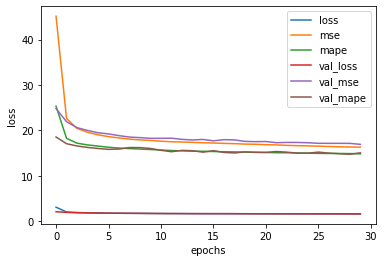

In [ ]:
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0))

In [ ]:
# Wide & deep neural network is not increasing model's performance

### Experiment with activation functions

In [ ]:
def build_model_activation(activation1,activation2,activation3):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Dense(25, activation=activation1))
  model.add(tf.keras.layers.Dense(25, activation=activation2))
  model.add(tf.keras.layers.Dense(25, activation=activation3))

  model.add(tf.keras.layers.Dense(1, activation='relu'))

  model.compile(loss = tf.keras.losses.mae,
              optimizer = 'adam',
              metrics = ['mse','mape']
              )
  return model

In [ ]:
keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_model_activation)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

params = {
  "activation1":['elu','relu','tanh','sigmoid'],
  "activation2":['elu','relu','tanh','sigmoid'],
  "activation3":['elu','relu','tanh','sigmoid']
}

rnd_search_cv = RandomizedSearchCV(estimator=keras_reg, cv=5, param_distributions=params, n_iter=10, scoring=['neg_mean_absolute_error','neg_mean_squared_error','neg_mean_absolute_percentage_error'], refit='neg_mean_absolute_error', random_state=42)

In [ ]:
rnd_result = rnd_search_cv.fit(taxi_train_features, taxi_train_labels, batch_size=128, epochs=10)

Epoch 1/10
6033/6033 [==============================] - 14s 2ms/step - loss: 11.3455 - mse: 222.2746 - mape: 100.0000
Epoch 2/10
6033/6033 [==============================] - 13s 2ms/step - loss: 11.3455 - mse: 222.2740 - mape: 100.0000
Epoch 3/10
6033/6033 [==============================] - 13s 2ms/step - loss: 11.3455 - mse: 222.2738 - mape: 100.0000
Epoch 4/10
6033/6033 [==============================] - 13s 2ms/step - loss: 11.3455 - mse: 222.2743 - mape: 100.0000
Epoch 5/10
6033/6033 [==============================] - 13s 2ms/step - loss: 11.3455 - mse: 222.2741 - mape: 100.0000
Epoch 6/10
6033/6033 [==============================] - 16s 3ms/step - loss: 11.3455 - mse: 222.2740 - mape: 100.0000
Epoch 7/10
6033/6033 [==============================] - 14s 2ms/step - loss: 11.3455 - mse: 222.2740 - mape: 100.0000
Epoch 8/10
6033/6033 [==============================] - 13s 2ms/step - loss: 11.3455 - mse: 222.2737 - mape: 100.0000
Epoch 9/10
6033/6033 [==============================] - 

In [ ]:
activations_rnd_results = pd.DataFrame(rnd_result.cv_results_)

In [ ]:
import joblib 

joblib.dump(activations_rnd_results,'activations_rnd_results.pkl')

['activations_rnd_results.pkl']

In [ ]:
from google.colab import files

files.download('activations_rnd_results.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib

In [ ]:
activations_rnd_results = joblib.load('activations_rnd_results.pkl')

In [ ]:
activations_rnd_results[['param_activation1','param_activation2','param_activation3','mean_test_neg_mean_absolute_error','rank_test_neg_mean_absolute_error']]

,param_activation1,param_activation2,param_activation3,mean_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,sigmoid,relu,elu,-3.574285,9
1,sigmoid,tanh,tanh,-1.644865,8
2,elu,elu,elu,-1.616196,5
3,tanh,sigmoid,elu,-1.622508,6
4,elu,relu,relu,-1.611433,4
5,tanh,relu,elu,-1.581297,1
6,relu,elu,elu,-1.590529,3
7,elu,sigmoid,elu,-1.631262,7
8,relu,tanh,relu,-1.588277,2
9,sigmoid,sigmoid,relu,-3.627867,10


In [ ]:
activations_rnd_results[['param_activation1','param_activation2','param_activation3','mean_test_neg_mean_squared_error','rank_test_neg_mean_squared_error']]

,param_activation1,param_activation2,param_activation3,mean_test_neg_mean_squared_error,rank_test_neg_mean_squared_error
0,sigmoid,relu,elu,-57.700569,9
1,sigmoid,tanh,tanh,-17.786864,8
2,elu,elu,elu,-16.914033,5
3,tanh,sigmoid,elu,-16.668430,1
4,elu,relu,relu,-16.798717,4
5,tanh,relu,elu,-16.688692,2
6,relu,elu,elu,-16.786098,3
7,elu,sigmoid,elu,-17.036546,6
8,relu,tanh,relu,-17.083304,7
9,sigmoid,sigmoid,relu,-58.305719,10


In [ ]:
activations_rnd_results[['param_activation1','param_activation2','param_activation3','mean_test_neg_mean_absolute_percentage_error','rank_test_neg_mean_absolute_percentage_error']]

,param_activation1,param_activation2,param_activation3,mean_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,sigmoid,relu,elu,-0.318063,9
1,sigmoid,tanh,tanh,-0.150309,8
2,elu,elu,elu,-0.146702,4
3,tanh,sigmoid,elu,-0.148169,6
4,elu,relu,relu,-0.148169,5
5,tanh,relu,elu,-0.144443,1
6,relu,elu,elu,-0.145038,3
7,elu,sigmoid,elu,-0.149563,7
8,relu,tanh,relu,-0.144912,2
9,sigmoid,sigmoid,relu,-0.325188,10


In [ ]:
# for first hidden layer - tanh is working best
# for second hidden layer - relu is working best
# for third hidden layer - elu is working best

In [ ]:
# MAE
print('MAE: ',list(-activations_rnd_results[(activations_rnd_results['param_activation1']=='tanh') & (activations_rnd_results['param_activation2']=='relu') & (activations_rnd_results['param_activation3']=='elu')]['mean_test_neg_mean_absolute_error'])[0],end='\n'+'-'*100+'\n')
# MSE
print('MSE: ',list(-activations_rnd_results[(activations_rnd_results['param_activation1']=='tanh') & (activations_rnd_results['param_activation2']=='relu') & (activations_rnd_results['param_activation3']=='elu')]['mean_test_neg_mean_squared_error'])[0],end='\n'+'-'*100+'\n')
# MAPE
print('MAPE: ',list(-activations_rnd_results[(activations_rnd_results['param_activation1']=='tanh') & (activations_rnd_results['param_activation2']=='relu') & (activations_rnd_results['param_activation3']=='elu')]['mean_test_neg_mean_absolute_percentage_error']*100)[0],end='\n'+'-'*100+'\n')

MAE:  1.581297324026019
----------------------------------------------------------------------------------------------------
MSE:  16.68869208714524
----------------------------------------------------------------------------------------------------
MAPE:  14.44427192859655
----------------------------------------------------------------------------------------------------


In [ ]:
activations_rnd_results = joblib.load('/content/activations_rnd_results.pkl')

### 95% confidence intervals

In [ ]:
import numpy as np
import scipy.stats as st

maes = np.array(-activations_rnd_results[(activations_rnd_results['param_activation1']=='tanh') & (activations_rnd_results['param_activation2']=='relu') & (activations_rnd_results['param_activation3']=='elu')].iloc[:,8:13]).reshape(5,)
mses = np.array(-activations_rnd_results[(activations_rnd_results['param_activation1']=='tanh') & (activations_rnd_results['param_activation2']=='relu') & (activations_rnd_results['param_activation3']=='elu')].iloc[:,16:21]).reshape(5,)
mapes = np.array(-activations_rnd_results[(activations_rnd_results['param_activation1']=='tanh') & (activations_rnd_results['param_activation2']=='relu') & (activations_rnd_results['param_activation3']=='elu')].iloc[:,24:29]*100).reshape(5,)

c1 = st.t.interval(alpha=0.95, df=len(maes)-1,
              loc=np.mean(maes),
              scale=st.sem(maes))

c2 = st.t.interval(alpha=0.95, df=len(mses)-1,
              loc=np.mean(mses),
              scale=st.sem(mses))

c3 = st.t.interval(alpha=0.95, df=len(mapes)-1,
              loc=np.mean(mapes),
              scale=st.sem(mapes))

print('95% confidence interval for mae:',c1)
print('95% confidence interval for mse:',c2)
print('95% confidence interval for mape:',c3)

95% confidence interval for mae: (1.573487003170253, 1.5891076448817851)
95% confidence interval for mse: (14.33444584832118, 19.042938325969303)
95% confidence interval for mape: (13.621160613049744, 15.267383244143355)


### Wide & Deep Neural Network

In [ ]:
# Let's build a wide and deep neural network with 3 hidden layers and following activation functions:

# hidden layer 1 - tanh
# hidden layer 2 - relu
# hidden layer 3 - elu

# output layer - relu (gives always positive result)

In [ ]:
input = tf.keras.layers.Input(shape=X_train.shape[1:])
hidden1 = tf.keras.layers.Dense(25, activation="tanh")(input)
hidden2 = tf.keras.layers.Dense(25, activation="relu")(hidden1)
hidden3 = tf.keras.layers.Dense(25, activation="elu")(hidden2)
concat = tf.keras.layers.Concatenate()([input,hidden3])
output = tf.keras.layers.Dense(1, activation="relu")(concat)
wide_n_deep_model = tf.keras.models.Model(inputs=[input], outputs=[output])

In [ ]:
wide_n_deep_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 25)           350         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 25)           650         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 25)           650         ['dense_1[0][0]']                
                                                                                              

In [ ]:
wide_n_deep_model.compile(loss = tf.keras.losses.mae,
            optimizer = 'adam',
            metrics = ['mse','mape']
            )

In [ ]:
history = wide_n_deep_model.fit(X_train, y_train, batch_size=128, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
5656/5656 [==============================] - 25s 4ms/step - loss: 2.0575 - mse: 22.7770 - mape: 18.4319 - val_loss: 1.7278 - val_mse: 18.7245 - val_mape: 15.3475
Epoch 2/30
5656/5656 [==============================] - 20s 4ms/step - loss: 1.6905 - mse: 17.4354 - mape: 15.4373 - val_loss: 1.6674 - val_mse: 18.1370 - val_mape: 14.8297
Epoch 3/30
5656/5656 [==============================] - 20s 4ms/step - loss: 1.6521 - mse: 17.0074 - mape: 15.1168 - val_loss: 1.6432 - val_mse: 17.8207 - val_mape: 14.6501
Epoch 4/30
5656/5656 [==============================] - 22s 4ms/step - loss: 1.6323 - mse: 16.7480 - mape: 14.9800 - val_loss: 1.6448 - val_mse: 17.5303 - val_mape: 14.6656
Epoch 5/30
5656/5656 [==============================] - 22s 4ms/step - loss: 1.6180 - mse: 16.5326 - mape: 14.8772 - val_loss: 1.6273 - val_mse: 17.1390 - val_mape: 14.9788
Epoch 6/30
5656/5656 [==============================] - 20s 4ms/step - loss: 1.6077 - mse: 16.3763 - mape: 14.7983 - val_loss: 1.6038 -

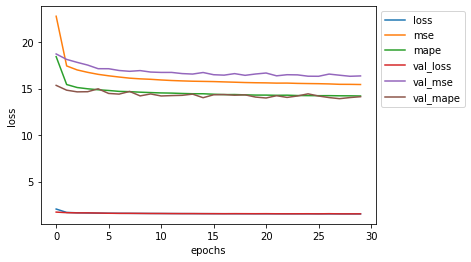

In [ ]:
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0))

In [ ]:
# performance of wide & deep neural network is more or less same not much increment in performance.

### Experiment with regularization techniques

#### Early stopping

In [ ]:
def build_model_early_stopping():
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Dense(25, activation='tanh'))
  model.add(tf.keras.layers.Dense(25, activation='relu'))
  model.add(tf.keras.layers.Dense(25, activation='elu'))

  model.add(tf.keras.layers.Dense(1, activation='relu'))

  model.compile(loss = tf.keras.losses.mae,
              optimizer = 'adam',
              metrics = ['mse','mape']
              )
  return model

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

early_stopping_res = {
        'mae' : [],
        'mse' : [],
        'mape' : []
}

features = np.array(taxi_train_features)
labels = np.array(taxi_train_labels)

fold_no = 1
for train, test in kf.split(features, labels):

  model = build_model_early_stopping()

  print(f'Training on fold {fold_no}:')

  history = model.fit(features[train], labels[train], batch_size=128, epochs=100, validation_data=(features[test], labels[test]), callbacks=[early_stopping_cb])

  scores = model.evaluate(features[test], labels[test])

  early_stopping_res['mae'].append(scores[0])
  early_stopping_res['mse'].append(scores[1])
  early_stopping_res['mape'].append(scores[2])

  fold_no = fold_no + 1

Training on fold 1:
Epoch 1/100
6033/6033 [==============================] - 21s 3ms/step - loss: 2.0185 - mse: 22.8587 - mape: 17.8895 - val_loss: 1.7524 - val_mse: 17.8552 - val_mape: 16.9408
Epoch 2/100
6033/6033 [==============================] - 20s 3ms/step - loss: 1.7199 - mse: 18.1008 - mape: 15.3066 - val_loss: 1.6930 - val_mse: 17.6880 - val_mape: 16.0596
Epoch 3/100
6033/6033 [==============================] - 20s 3ms/step - loss: 1.6686 - mse: 17.7192 - mape: 14.8309 - val_loss: 1.6667 - val_mse: 17.4266 - val_mape: 15.7466
Epoch 4/100
6033/6033 [==============================] - 20s 3ms/step - loss: 1.6357 - mse: 17.4258 - mape: 14.6087 - val_loss: 1.6204 - val_mse: 16.9331 - val_mape: 15.6628
Epoch 5/100
6033/6033 [==============================] - 23s 4ms/step - loss: 1.6170 - mse: 17.2571 - mape: 14.5187 - val_loss: 1.6064 - val_mse: 16.7361 - val_mape: 15.6825
Epoch 6/100
6033/6033 [==============================] - 20s 3ms/step - loss: 1.6058 - mse: 17.1235 - mape: 14

In [ ]:
taxi_early_stopping_res = pd.DataFrame(early_stopping_res)

In [ ]:
taxi_early_stopping_res

,mae,mse,mape
0,1.524529,15.494973,15.150228
1,1.525012,18.720997,14.157515
2,1.516085,14.946985,13.660444
3,1.508520,14.452158,13.694985
4,1.504866,13.325739,13.762249


In [ ]:
taxi_early_stopping_res = pd.read_csv('/content/taxi_early_stopping_res.csv')

In [ ]:
print('Average mae from early stopping:',taxi_early_stopping_res['mae'].mean())

Average mae from early stopping: 1.5158023999999999


In [ ]:
import numpy as np
import scipy.stats as st

maes = np.array(taxi_early_stopping_res['mae'])
mses = np.array(taxi_early_stopping_res['mse'])
mapes = np.array(taxi_early_stopping_res['mape'])

c1 = st.t.interval(alpha=0.95, df=len(maes)-1,
              loc=np.mean(maes),
              scale=st.sem(maes))

c2 = st.t.interval(alpha=0.95, df=len(mses)-1,
              loc=np.mean(mses),
              scale=st.sem(mses))

c3 = st.t.interval(alpha=0.95, df=len(mapes)-1,
              loc=np.mean(mapes),
              scale=st.sem(mapes))

print('95% confidence interval for mae:',c1)
print('95% confidence interval for mse:',c2)
print('95% confidence interval for mape:',c3)

95% confidence interval for mae: (1.5044615760873221, 1.5271432239126776)
95% confidence interval for mse: (12.870658215822498, 17.905682584177498)
95% confidence interval for mape: (13.305576089262075, 14.864592310737926)


In [ ]:
# early dropouts increasing the performance

#### Dropout rate

In [ ]:
def build_model_dropout():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dropout(rate=0.3)),
  model.add(tf.keras.layers.Dense(25, activation='tanh'))
  model.add(tf.keras.layers.Dropout(rate=0.3)),
  model.add(tf.keras.layers.Dense(25, activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.3)),
  model.add(tf.keras.layers.Dense(25, activation='elu'))
  model.add(tf.keras.layers.Dropout(rate=0.3)),
  model.add(tf.keras.layers.Dense(1, activation='relu'))

  model.compile(loss = tf.keras.losses.mae,
              optimizer = 'adam',
              metrics = ['mse','mape']
              )
  return model

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

dropout_res = {
        'mae' : [],
        'mse' : [],
        'mape' : []
}

features = np.array(taxi_train_features)
labels = np.array(taxi_train_labels)

fold_no = 1
for train, test in kf.split(features, labels):

  model = build_model_dropout()

  print(f'Training on fold {fold_no}:')

  history = model.fit(features[train], labels[train], batch_size=128, epochs=100, validation_data=(features[test], labels[test]), callbacks=[early_stopping_cb])

  scores = model.evaluate(features[test], labels[test])

  dropout_res['mae'].append(scores[0])
  dropout_res['mse'].append(scores[1])
  dropout_res['mape'].append(scores[2])

  fold_no = fold_no + 1

Training on fold 1:
Epoch 1/100
6033/6033 [==============================] - 21s 3ms/step - loss: 3.6036 - mse: 45.8251 - mape: 32.9624 - val_loss: 2.6283 - val_mse: 27.8916 - val_mape: 25.1886
Epoch 2/100
6033/6033 [==============================] - 21s 3ms/step - loss: 3.1844 - mse: 37.3849 - mape: 28.9054 - val_loss: 2.6787 - val_mse: 27.0657 - val_mape: 26.7115
Epoch 3/100
6033/6033 [==============================] - 20s 3ms/step - loss: 3.1092 - mse: 36.2443 - mape: 28.4414 - val_loss: 2.7702 - val_mse: 27.9440 - val_mape: 27.7161
Epoch 4/100
6033/6033 [==============================] - 21s 3ms/step - loss: 3.0774 - mse: 35.7945 - mape: 27.9259 - val_loss: 2.7144 - val_mse: 27.1770 - val_mape: 27.2582
Epoch 5/100
6033/6033 [==============================] - 21s 3ms/step - loss: 3.0559 - mse: 35.3479 - mape: 28.2158 - val_loss: 2.7502 - val_mse: 27.1046 - val_mape: 28.7614
Epoch 6/100
6033/6033 [==============================] - 20s 3ms/step - loss: 3.0476 - mse: 35.4049 - mape: 28

In [ ]:
taxi_dropout_res = pd.DataFrame(dropout_res)

In [ ]:
taxi_dropout_res

,mae,mse,mape
0,2.628329,27.891539,25.188656
1,2.657085,31.405504,24.660173
2,2.634037,25.635416,25.561306
3,2.677886,26.393520,26.398125
4,2.530481,25.027672,23.923609


In [ ]:
taxi_dropout_res = pd.read_csv('/content/taxi_dropout_res.csv')

In [ ]:
print('Average mae from random dropouts + early stopping:',taxi_dropout_res['mae'].mean())

Average mae from random dropouts + early stopping: 2.6255636


In [ ]:
import numpy as np
import scipy.stats as st

maes = np.array(taxi_dropout_res['mae'])
mses = np.array(taxi_dropout_res['mse'])
mapes = np.array(taxi_dropout_res['mape'])

c1 = st.t.interval(alpha=0.95, df=len(maes)-1,
              loc=np.mean(maes),
              scale=st.sem(maes))

c2 = st.t.interval(alpha=0.95, df=len(mses)-1,
              loc=np.mean(mses),
              scale=st.sem(mses))

c3 = st.t.interval(alpha=0.95, df=len(mapes)-1,
              loc=np.mean(mapes),
              scale=st.sem(mapes))

print('95% confidence interval for mae:',c1)
print('95% confidence interval for mse:',c2)
print('95% confidence interval for mape:',c3)

95% confidence interval for mae: (2.555183649251607, 2.695943550748393)
95% confidence interval for mse: (24.10772561200733, 30.433734787992663)
95% confidence interval for mape: (23.989494963704143, 26.303252636295856)


In [ ]:
# random dropouts degrading the performance.

### L1 for sparse model

In [ ]:
def build_model_l1():
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Dense(25, activation='tanh', kernel_regularizer=tf.keras.regularizers.l1(0.0001)))
  model.add(tf.keras.layers.Dense(25, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.0001)))
  model.add(tf.keras.layers.Dense(25, activation='elu', kernel_regularizer=tf.keras.regularizers.l1(0.0001)))

  model.add(tf.keras.layers.Dense(1, activation='relu'))

  model.compile(loss = tf.keras.losses.mae,
              optimizer = 'adam',
              metrics = ['mse','mape']
              )
  return model

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

l1_res = {
        'mae' : [],
        'mse' : [],
        'mape' : []
}

features = np.array(taxi_train_features)
labels = np.array(taxi_train_labels)

fold_no = 1
for train, test in kf.split(features, labels):

  model = build_model_l1()

  print(f'Training on fold {fold_no}:')

  history = model.fit(features[train], labels[train], batch_size=128, epochs=100, validation_data=(features[test], labels[test]), callbacks=[early_stopping_cb])

  scores = model.evaluate(features[test], labels[test])

  l1_res['mae'].append(scores[0])
  l1_res['mse'].append(scores[1])
  l1_res['mape'].append(scores[2])

  fold_no = fold_no + 1

Training on fold 1:
Epoch 1/100
6033/6033 [==============================] - 22s 3ms/step - loss: 2.0417 - mse: 23.0819 - mape: 17.7626 - val_loss: 1.7314 - val_mse: 17.5325 - val_mape: 16.5223
Epoch 2/100
6033/6033 [==============================] - 15s 3ms/step - loss: 1.7128 - mse: 17.5843 - mape: 15.0325 - val_loss: 1.6988 - val_mse: 17.4094 - val_mape: 15.9187
Epoch 3/100
6033/6033 [==============================] - 16s 3ms/step - loss: 1.6840 - mse: 17.3008 - mape: 14.7973 - val_loss: 1.6908 - val_mse: 17.2087 - val_mape: 15.9200
Epoch 4/100
6033/6033 [==============================] - 15s 3ms/step - loss: 1.6665 - mse: 17.0622 - mape: 14.6802 - val_loss: 1.6641 - val_mse: 16.7474 - val_mape: 16.0267
Epoch 5/100
6033/6033 [==============================] - 16s 3ms/step - loss: 1.6539 - mse: 16.8443 - mape: 14.5994 - val_loss: 1.6502 - val_mse: 16.4538 - val_mape: 16.2859
Epoch 6/100
6033/6033 [==============================] - 15s 3ms/step - loss: 1.6434 - mse: 16.6964 - mape: 14

In [ ]:
taxi_l1_res = pd.DataFrame(l1_res)

In [ ]:
taxi_l1_res

,mae,mse,mape
0,1.559691,15.519661,14.941443
1,1.571352,18.531313,15.086568
2,1.574958,15.448649,13.807055
3,1.558307,14.597572,13.743796
4,1.547467,14.759685,13.487288


In [ ]:
taxi_l1_res = pd.read_csv('/content/taxi_l1_res.csv')

In [ ]:
print('Average mae from l1 regularization:',taxi_l1_res['mae'].mean())

Average mae from l1 regularization: 1.5623550000000002


In [ ]:
import numpy as np
import scipy.stats as st

maes = np.array(taxi_l1_res['mae'])
mses = np.array(taxi_l1_res['mse'])
mapes = np.array(taxi_l1_res['mape'])

c1 = st.t.interval(alpha=0.95, df=len(maes)-1,
              loc=np.mean(maes),
              scale=st.sem(maes))

c2 = st.t.interval(alpha=0.95, df=len(mses)-1,
              loc=np.mean(mses),
              scale=st.sem(mses))

c3 = st.t.interval(alpha=0.95, df=len(mapes)-1,
              loc=np.mean(mapes),
              scale=st.sem(mapes))

print('95% confidence interval for mae:',c1)
print('95% confidence interval for mse:',c2)
print('95% confidence interval for mape:',c3)

95% confidence interval for mae: (1.5486837583362922, 1.576026241663708)
95% confidence interval for mse: (13.789949079498703, 17.752802920501296)
95% confidence interval for mape: (13.291268010867482, 15.135191989132517)


In [ ]:
# Among all regularization techniques early stopping is working best.

### Experiment with at least 2 more Optimizers 

In [ ]:
def build_model_optimizer(opt):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Dense(25, activation='tanh'))
  model.add(tf.keras.layers.Dense(25, activation='relu'))
  model.add(tf.keras.layers.Dense(25, activation='elu'))

  model.add(tf.keras.layers.Dense(1, activation='relu'))

  model.compile(loss = tf.keras.losses.mae,
              optimizer = opt,
              metrics = ['mse','mape']
              )
  return model

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

optimizer_res = {
  'nadam':{
      'mae' : [],
      'mse' : [],
      'mape' : []
  },
  'adam':{
      'mae' : [],
      'mse' : [],
      'mape' : []      
  },
  'sgd':{
      'mae' : [],
      'mse' : [],
      'mape' : []      
  }
}

features = np.array(taxi_train_features)
labels = np.array(taxi_train_labels)

optimizers = ['nadam','adam','sgd'];

for opt in optimizers:
  fold_no = 1
  print(f'Optimizer: {opt}')
  for train, test in kf.split(features, labels):

    model = build_model_optimizer(opt)

    print(f'Training on fold {fold_no}:')

    history = model.fit(features[train], labels[train], batch_size=128, epochs=15, validation_data=(features[test], labels[test]))

    scores = model.evaluate(features[test], labels[test])

    optimizer_res[opt]['mae'].append(scores[0])
    optimizer_res[opt]['mse'].append(scores[1])
    optimizer_res[opt]['mape'].append(scores[2])

    fold_no = fold_no + 1

Optimizer: nadam
Training on fold 1:
Epoch 1/15
6033/6033 [==============================] - 17s 3ms/step - loss: 2.0120 - mse: 22.8722 - mape: 17.8762 - val_loss: 1.7592 - val_mse: 17.8436 - val_mape: 17.3934
Epoch 2/15
6033/6033 [==============================] - 16s 3ms/step - loss: 1.7216 - mse: 18.0312 - mape: 15.3824 - val_loss: 1.6979 - val_mse: 17.6452 - val_mape: 16.1114
Epoch 3/15
6033/6033 [==============================] - 15s 3ms/step - loss: 1.6771 - mse: 17.6800 - mape: 14.9570 - val_loss: 1.6553 - val_mse: 17.1890 - val_mape: 16.0974
Epoch 4/15
6033/6033 [==============================] - 16s 3ms/step - loss: 1.6448 - mse: 17.4325 - mape: 14.7126 - val_loss: 1.6329 - val_mse: 16.9820 - val_mape: 15.8985
Epoch 5/15
6033/6033 [==============================] - 17s 3ms/step - loss: 1.6252 - mse: 17.2885 - mape: 14.5291 - val_loss: 1.6180 - val_mse: 16.8403 - val_mape: 15.9112
Epoch 6/15
6033/6033 [==============================] - 19s 3ms/step - loss: 1.6128 - mse: 17.1157

In [ ]:
taxi_sgd_optimizer = pd.DataFrame(optimizer_res['sgd'])
taxi_sgd_optimizer

,mae,mse,mape
0,1.602035,16.733749,15.873131
1,1.609825,19.833300,14.415371
2,1.628909,17.082205,14.090411
3,1.671591,16.547112,14.226391
4,1.603428,15.233127,14.044757


In [ ]:
import joblib

joblib.dump(taxi_sgd_optimizer,'taxi_sgd_optimizer.pkl')

['taxi_sgd_optimizer.pkl']

In [ ]:
from google.colab import files

files.download('taxi_sgd_optimizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import scipy.stats as st

maes = np.array(taxi_sgd_optimizer['mae'])
mses = np.array(taxi_sgd_optimizer['mse'])
mapes = np.array(taxi_sgd_optimizer['mape'])

c1 = st.t.interval(alpha=0.95, df=len(maes)-1,
              loc=np.mean(maes),
              scale=st.sem(maes))

c2 = st.t.interval(alpha=0.95, df=len(mses)-1,
              loc=np.mean(mses),
              scale=st.sem(mses))

c3 = st.t.interval(alpha=0.95, df=len(mapes)-1,
              loc=np.mean(mapes),
              scale=st.sem(mapes))

print('95% confidence interval for mae:',c1)
print('95% confidence interval for mse:',c2)
print('95% confidence interval for mape:',c3)

95% confidence interval for mae: (1.586999750485923, 1.6593160625786523)
95% confidence interval for mse: (14.990161324553421, 19.181635474152635)
95% confidence interval for mape: (13.580724093504383, 15.479300167970226)


In [ ]:
print('Average mae with sgd optimizer:',taxi_sgd_optimizer['mae'].mean())

Average mae with sgd optimizer: 1.6231579065322876


In [ ]:
taxi_adam_optimizer = pd.DataFrame(optimizer_res['adam'])
taxi_adam_optimizer

,mae,mse,mape
0,1.575302,16.223715,15.439157
1,1.582664,19.538916,14.615983
2,1.586303,16.487122,14.047811
3,1.554943,15.235044,14.148807
4,1.575220,14.800370,14.377466


In [ ]:
import joblib

joblib.dump(taxi_adam_optimizer,'taxi_adam_optimizer.pkl')

['taxi_adam_optimizer.pkl']

In [ ]:
from google.colab import files

files.download('taxi_adam_optimizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print('Average mae with adam optimizer:',taxi_adam_optimizer['mae'].mean())

Average mae with adam optimizer: 1.5748864650726317


In [ ]:
import numpy as np
import scipy.stats as st

maes = np.array(taxi_adam_optimizer['mae'])
mses = np.array(taxi_adam_optimizer['mse'])
mapes = np.array(taxi_adam_optimizer['mape'])

c1 = st.t.interval(alpha=0.95, df=len(maes)-1,
              loc=np.mean(maes),
              scale=st.sem(maes))

c2 = st.t.interval(alpha=0.95, df=len(mses)-1,
              loc=np.mean(mses),
              scale=st.sem(mses))

c3 = st.t.interval(alpha=0.95, df=len(mapes)-1,
              loc=np.mean(mapes),
              scale=st.sem(mapes))

print('95% confidence interval for mae:',c1)
print('95% confidence interval for mse:',c2)
print('95% confidence interval for mape:',c3)

95% confidence interval for mae: (1.5598212473776925, 1.589951682767571)
95% confidence interval for mse: (14.1514856871342, 18.762580627563064)
95% confidence interval for mape: (13.835923386531706, 15.215765761417513)


In [ ]:
taxi_nadam_optimizer = pd.DataFrame(optimizer_res['nadam'])
taxi_nadam_optimizer

,mae,mse,mape
0,1.563002,16.119001,15.175482
1,1.578724,19.460167,14.616126
2,1.577628,15.985617,14.078624
3,1.576463,15.472116,14.408840
4,1.558455,14.738717,14.037695


In [ ]:
import joblib

joblib.dump(taxi_nadam_optimizer,'taxi_nadam_optimizer.pkl')

['taxi_nadam_optimizer.pkl']

In [ ]:
from google.colab import files

files.download('taxi_nadam_optimizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print('Average mae with nadam optimizer:',taxi_nadam_optimizer['mae'].mean())

Average mae with nadam optimizer: 1.5708543300628661


In [ ]:
import numpy as np
import scipy.stats as st

maes = np.array(taxi_nadam_optimizer['mae'])
mses = np.array(taxi_nadam_optimizer['mse'])
mapes = np.array(taxi_nadam_optimizer['mape'])

c1 = st.t.interval(alpha=0.95, df=len(maes)-1,
              loc=np.mean(maes),
              scale=st.sem(maes))

c2 = st.t.interval(alpha=0.95, df=len(mses)-1,
              loc=np.mean(mses),
              scale=st.sem(mses))

c3 = st.t.interval(alpha=0.95, df=len(mapes)-1,
              loc=np.mean(mapes),
              scale=st.sem(mapes))

print('95% confidence interval for mae:',c1)
print('95% confidence interval for mse:',c2)
print('95% confidence interval for mape:',c3)

95% confidence interval for mae: (1.5591626137948995, 1.5825460463308327)
95% confidence interval for mse: (14.097303707931035, 18.61294333186389)
95% confidence interval for mape: (13.886734409952334, 15.039972285604305)


In [ ]:
# Among all optimizers sgd is performing worse and nadam is performing best.

### Final Model

In [ ]:
# specifications:

# hidden layers: 3 hidden layers
# number of neurons in each hidden layer: 25

# activation function in hidden layer1: tanh
# activation function in hidden layer2: relu
# activation function in hidden layer3: elu

# activation function in output layer: relu

# regularizer: early stopping

# optimizer: nadam

In [ ]:
taxi_final_model = tf.keras.models.Sequential()

taxi_final_model.add(tf.keras.layers.Dense(25, activation='tanh'))
taxi_final_model.add(tf.keras.layers.Dense(25, activation='relu'))
taxi_final_model.add(tf.keras.layers.Dense(25, activation='elu'))

taxi_final_model.add(tf.keras.layers.Dense(1, activation='relu'))

taxi_final_model.compile(loss = tf.keras.losses.mae,
            optimizer = 'nadam',
            metrics = ['mse','mape']
            )

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = taxi_final_model.fit(taxi_train_features, taxi_train_labels, batch_size=128, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100
7541/7541 [==============================] - 21s 3ms/step - loss: 2.0191 - mse: 22.2335 - mape: 18.2622 - val_loss: 1.7956 - val_mse: 18.6890 - val_mape: 16.9128
Epoch 2/100
7541/7541 [==============================] - 19s 3ms/step - loss: 1.7067 - mse: 17.6391 - mape: 15.5297 - val_loss: 1.6817 - val_mse: 17.9264 - val_mape: 15.4859
Epoch 3/100
7541/7541 [==============================] - 19s 2ms/step - loss: 1.6524 - mse: 17.1835 - mape: 14.9738 - val_loss: 1.6333 - val_mse: 17.7882 - val_mape: 14.5367
Epoch 4/100
7541/7541 [==============================] - 19s 3ms/step - loss: 1.6274 - mse: 16.9071 - mape: 14.7854 - val_loss: 1.6131 - val_mse: 17.4841 - val_mape: 14.5560
Epoch 5/100
7541/7541 [==============================] - 19s 3ms/step - loss: 1.6112 - mse: 16.7632 - mape: 14.6561 - val_loss: 1.6168 - val_mse: 17.2781 - val_mape: 15.0319
Epoch 6/100
7541/7541 [==============================] - 19s 2ms/step - loss: 1.5996 - mse: 16.6541 - mape: 14.5759 - val_loss: 1.

In [ ]:
taxi_final_model.save('taxi_final_model.h5')

In [ ]:
files.download('taxi_final_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Prediction

In [ ]:
y_pred = taxi_final_model.predict(taxi_test).reshape(50,)

In [ ]:
test_id = [i for i in range(50)]

In [ ]:
ny_taxi_submission = pd.DataFrame({'test_id':test_id,'fare_amount':y_pred})

In [ ]:
ny_taxi_submission

,test_id,fare_amount
0,0,17.585075
1,1,10.314673
2,2,9.614437
3,3,10.089620
4,4,10.103703
5,5,10.440918
6,6,10.363193
7,7,10.430140
8,8,10.448386
9,9,10.067374


In [ ]:
ny_taxi_submission.to_csv('ny_taxi_submission.csv')